In [1]:
!pip install -U kaleido

In [2]:
import time
import numpy as np
import pandas as pd
import polars as pl
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import plotly.io as pio

pio.renderers.default ='iframe'

%matplotlib inline

In [3]:
prior_product_orders = pl.read_csv("/kaggle/input/instacart-market-basket-analysis/order_products__prior.csv")
train_product_orders = pl.read_csv("/kaggle/input/instacart-market-basket-analysis/order_products__train.csv")
departments_df = pl.read_csv("/kaggle/input/instacart-market-basket-analysis/departments.csv")
aisels_df = pl.read_csv("/kaggle/input/instacart-market-basket-analysis/aisles.csv")
orders_df = pl.read_csv("/kaggle/input/instacart-market-basket-analysis/orders.csv")
products_df = pl.read_csv("/kaggle/input/instacart-market-basket-analysis/products.csv")

In [4]:
def get_time(start):
    return time.time()-start

In [5]:
df_list = [prior_product_orders,orders_df,train_product_orders,products_df,aisels_df,departments_df]

In [6]:
prior_product_orders.schema

Schema([('order_id', Int64),
        ('product_id', Int64),
        ('add_to_cart_order', Int64),
        ('reordered', Int64)])

In [7]:
orders_df.schema

Schema([('order_id', Int64),
        ('user_id', Int64),
        ('eval_set', String),
        ('order_number', Int64),
        ('order_dow', Int64),
        ('order_hour_of_day', Int64),
        ('days_since_prior_order', Float64)])

In [8]:
aisels_df.schema

Schema([('aisle_id', Int64), ('aisle', String)])

In [9]:
products_df.schema

Schema([('product_id', Int64),
        ('product_name', String),
        ('aisle_id', Int64),
        ('department_id', Int64)])

In [10]:
# let's check for null values.
for df in df_list:
    print(df.null_count())

# as we can see only days_since_prior_order contains null as first order hasn't any prior orders.

shape: (1, 4)
┌──────────┬────────────┬───────────────────┬───────────┐
│ order_id ┆ product_id ┆ add_to_cart_order ┆ reordered │
│ ---      ┆ ---        ┆ ---               ┆ ---       │
│ u32      ┆ u32        ┆ u32               ┆ u32       │
╞══════════╪════════════╪═══════════════════╪═══════════╡
│ 0        ┆ 0          ┆ 0                 ┆ 0         │
└──────────┴────────────┴───────────────────┴───────────┘
shape: (1, 7)
┌──────────┬─────────┬──────────┬──────────────┬───────────┬───────────────────┬───────────────────┐
│ order_id ┆ user_id ┆ eval_set ┆ order_number ┆ order_dow ┆ order_hour_of_day ┆ days_since_prior_ │
│ ---      ┆ ---     ┆ ---      ┆ ---          ┆ ---       ┆ ---               ┆ order             │
│ u32      ┆ u32     ┆ u32      ┆ u32          ┆ u32       ┆ u32               ┆ ---               │
│          ┆         ┆          ┆              ┆           ┆                   ┆ u32               │
╞══════════╪═════════╪══════════╪══════════════╪═══════════╪═

In [11]:
# is there anything unusal in the days_since_prior_orders
print(orders_df.filter(pl.col("order_number") != 1).select("days_since_prior_order").null_count())

shape: (1, 1)
┌────────────────────────┐
│ days_since_prior_order │
│ ---                    │
│ u32                    │
╞════════════════════════╡
│ 0                      │
└────────────────────────┘


In [12]:
# let's check for the label consistency 

print(prior_product_orders['reordered'].n_unique())
print(train_product_orders['reordered'].n_unique())

2
2


In [13]:
# let's check differenct eval_set
print(orders_df['eval_set'].unique())

shape: (3,)
Series: 'eval_set' [str]
[
	"test"
	"train"
	"prior"
]


In [14]:
# let's check consistency of the order_df
print(orders_df['order_dow'].unique())
print(orders_df['order_hour_of_day'].unique())

shape: (7,)
Series: 'order_dow' [i64]
[
	0
	1
	2
	3
	4
	5
	6
]
shape: (24,)
Series: 'order_hour_of_day' [i64]
[
	0
	1
	2
	3
	4
	…
	19
	20
	21
	22
	23
]


In [15]:
# looking for outliers in days_since_prior_orders 

orders_df['days_since_prior_order'].max()

30.0

## Distribution plots 

In [51]:
def plot_categorical_column(column_name,df):
    data = df[column_name].value_counts().to_pandas()
    data[column_name] = data[column_name].astype(str)
    fig = px.bar(
        data,
        x = f'{column_name}',
        y = 'count'
    )
    fig.update_layout(
        title = f'{column_name} w.r.t count',
        xaxis_title = f'{column_name}',
        yaxis_title = 'count'
    )
    pio.write_image(fig,f'{column_name} w.r.t count.png')
    fig.show()

### prior product orders dataframe's columns

Two main purpose:-
1. looking for anomoly
2. looking for any pattern

In [17]:
# Create a histogram using Plotly Express
data =  prior_product_orders.select("add_to_cart_order").to_pandas()
fig = px.histogram(data,x='add_to_cart_order', nbins=30, labels={'x': 'add_to_cart_order'})

# Show the figure
fig.show()


1. Looking fine
2. no such pattern

In [18]:
# let's view the distribution of the label
plot_categorical_column("reordered",prior_product_orders)

1. Looking fine though little bit imbalance
2. no such pattern

### orders dataframe's columns

In [19]:
plot_categorical_column("eval_set",orders_df)

1. Looking fine
2. no such pattern

In [20]:
plot_categorical_column("order_dow",orders_df.sort('order_dow'))

1. Looking fine
2. I think 0 , 1 represents holidays.

In [52]:
plot_categorical_column("days_since_prior_order",orders_df.sort('days_since_prior_order'))

1. I think they have capped to 30.
2. people has higher probabilites to order within day after 7 day or after 30 days

In [22]:
plot_categorical_column("order_number",orders_df.sort("order_number"))

1. Looking fine
2. i think customers who have atleast 3 prior orders has been taken.

let's explore more

Maximum user wise order number

In [23]:
data = (
    orders_df.select("order_number","user_id")
            .group_by("user_id")
            .agg(
                pl.max("order_number").alias("maximum_orders")
            ).sort("maximum_orders")
)
data = data.to_pandas()

In [24]:
fig = px.histogram(
    x = data['maximum_orders']
)
fig.show()

so maximum orders is capped to 100.

## Outlier and statistics analysis

In [25]:
def box_plot(column_name,df):
    data = df.select(pl.col(column_name).drop_nulls()).to_numpy()
    data = data.squeeze()
    fig = plt.figure(figsize =(10, 7))
    plt.title(f"box plot for {column_name}")
    plt.boxplot(data)
    plt.show()

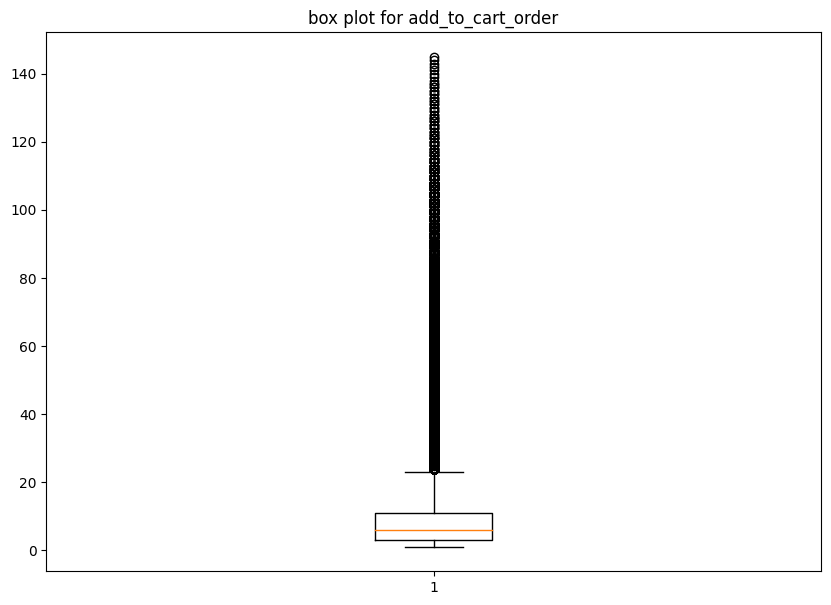

In [26]:
box_plot("add_to_cart_order",prior_product_orders)

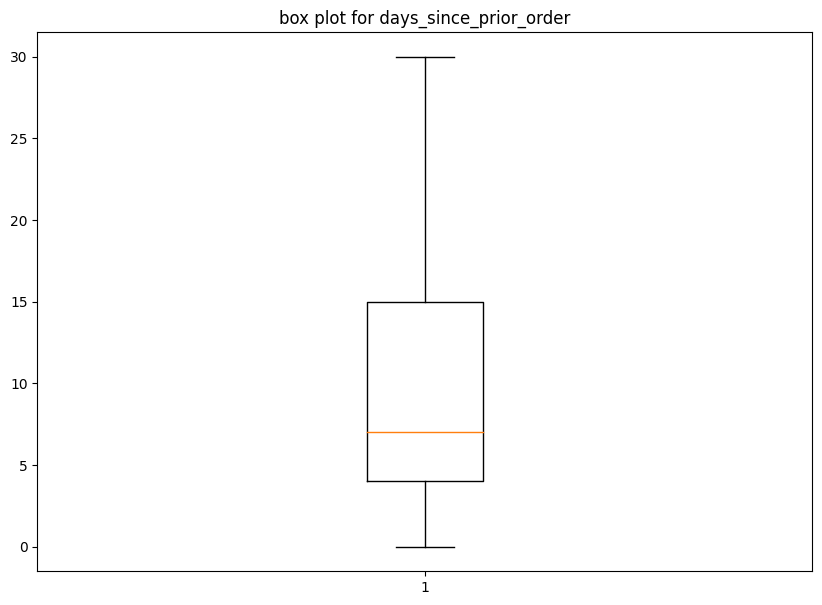

In [27]:
box_plot("days_since_prior_order",orders_df)

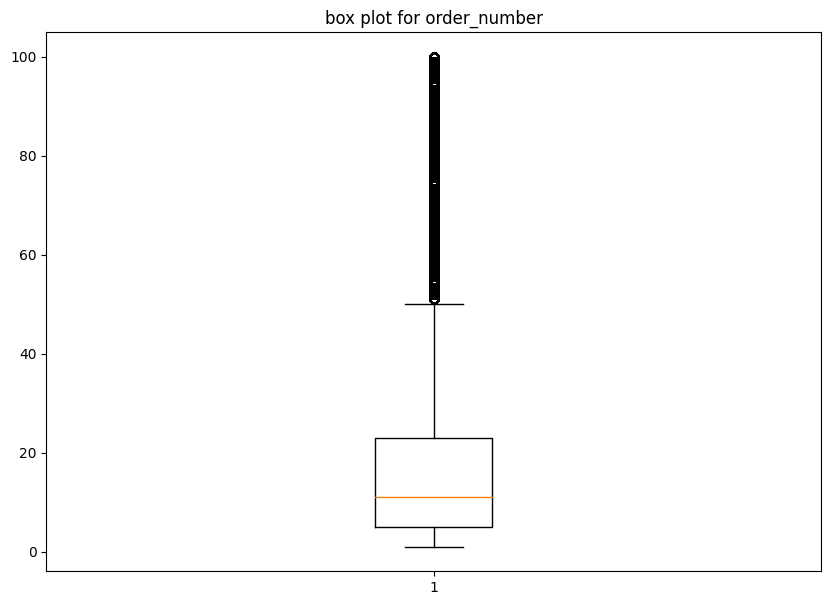

In [28]:
box_plot('order_number',orders_df)

## Correlation between variables

### Continuos variables

Bivariate Analysis

In [29]:
x = orders_df.filter(pl.col('days_since_prior_order').is_null() == False).select("order_number").to_numpy()
y = orders_df.filter(pl.col('days_since_prior_order').is_null() == False).select("days_since_prior_order").to_numpy()

rho, p_value = stats.spearmanr(x, y)
 
print("Spearman correlation coefficient:", rho)

rho, p_value = stats.pearsonr(x, y)
 
print("pearson correlation coefficient:", rho)

Spearman correlation coefficient: -0.3879745599157059
pearson correlation coefficient: [-0.36056365]


In [30]:
# Create a contingency table by grouping and counting
contingency_df = (
    orders_df
    .group_by(["order_dow", "order_hour_of_day"])
    .count()
    .pivot(values="count", columns="order_hour_of_day", index="order_dow")
)

# Convert to NumPy for chi-square test
contingency_table = contingency_df.to_numpy()

chi2_stat, p_value, dof, expected = stats.chi2_contingency(contingency_table)

print("Chi-square statistic:", chi2_stat)
print("P-value:", p_value)

/tmp/ipykernel_1068/2548284510.py:5: DeprecationWarning:

`GroupBy.count` is deprecated. It has been renamed to `len`.



Chi-square statistic: 13734.728043359813
P-value: 0.0


/tmp/ipykernel_1068/2548284510.py:3: DeprecationWarning:

The argument `columns` for `DataFrame.pivot` is deprecated. It has been renamed to `on`.



In [31]:
count_df  = (
    orders_df
    .group_by(["order_dow", "order_hour_of_day"])
    .count()
    .sort(['order_dow','order_hour_of_day'])
)

/tmp/ipykernel_1068/1165128553.py:4: DeprecationWarning:

`GroupBy.count` is deprecated. It has been renamed to `len`.



In [32]:
count_df = count_df.to_pandas()
count_df[['order_dow','order_hour_of_day']] = count_df[['order_dow','order_hour_of_day']].astype(str)
fig = px.line(
    count_df,
    x = 'order_hour_of_day',
    y='count',
    color='order_dow',
    markers = True
)
fig.update_layout(
    title = 'order distribution w.r.t order hour of day',
    xaxis_title = 'order hour of day',
    yaxis_title ='count of orders'
)
pio.write_image(fig, "order distribution w.r.t order hour of day.png")
fig.show()

As We can see 0,1 days are high order days. and order hour of day 8 to 16 are sweet spots.

In [33]:
prior_product_orders_with_prod_details = (
    prior_product_orders.join(
        products_df,on='product_id',how='inner'
    )
)

In [34]:
organic_reordered_contigency_df = (
    prior_product_orders_with_prod_details.select('product_name','reordered')
                                            .with_columns(
                                                is_organic = pl.col("product_name").str.contains("(?i)Organic")
                                            )
                                            .group_by("is_organic","reordered")
                                            .len()
                                            .pivot(
                                                index='is_organic',columns = 'reordered' , values = 'len'
                                            )
)

/tmp/ipykernel_1068/1988500167.py:2: DeprecationWarning:

The argument `columns` for `DataFrame.pivot` is deprecated. It has been renamed to `on`.



In [35]:
organic_reordered_contigency_df=organic_reordered_contigency_df.to_pandas()
organic_reordered_contigency_df['is_organic'] = organic_reordered_contigency_df['is_organic'].replace({True:'Organic',False:'Not Organic'})
organic_reordered_contigency_df = organic_reordered_contigency_df.set_index("is_organic")
fig = px.bar(
    x = organic_reordered_contigency_df.index ,
    y = organic_reordered_contigency_df.sum(axis=1)
)
fig.show()

In [44]:
fig = px.bar(
    x = organic_reordered_contigency_df.index ,
    y = organic_reordered_contigency_df['1'] / organic_reordered_contigency_df.sum(axis=1) * 100
)
fig.update_layout(
    title = 'product types vs reorder probability',
    xaxis_title = 'product type (Organic vs Inorganic)',
    yaxis_title = 'reorder probability'
)
pio.write_image(fig,'product type (Organic vs Inorganic).png')
fig.show()

Organic  proudcts have higher percentage reorder probability.

let's visualize departments and aisels.

In [37]:
data = (
    products_df.join(
        departments_df,on = "department_id",how = 'inner'
    ).join(
        aisels_df, on = 'aisle_id',how='inner'
    ).group_by("department","aisle")
    .agg(
        pl.count('product_id').alias("prod_count_p_aisle")
    ).with_columns(
        aisle_with_br = pl.col("aisle").str.replace(" ","<br>")
    )
)


In [38]:
fig = px.treemap(
    data,
    path = [px.Constant("departments"),'department','aisle_with_br'],
    values = 'prod_count_p_aisle',
    # color = 'prod_count_p_aisle'
)

# Update trace with larger font size specifically for smaller sections
fig.update_traces(
    marker=dict(line=dict(width=0.2)),
    textinfo="label",  # Show label and values
    insidetextfont=dict(size=16),  # Text size for inner levels
    root_color="lightgrey"  # Adds a background color for better hierarchy readability
)
fig.update_layout(
    width = 700,
     margin=dict(l=0, r=0, t=0, b=0)
)
fig.show()

In [46]:
data = (
    orders_df.filter(pl.col("eval_set") == 'prior').join(
        prior_product_orders , on ='order_id', how= 'left'
    ).join(
        products_df,on='product_id',how='left'
    ).join(
        departments_df,on='department_id',how='left'
    ).group_by("department")
    .agg(
      pl.len().alias("total_prod_sold"),
        pl.sum("reordered").alias("reorder_count")
    ).with_columns(
        reorder_percentage = pl.col('reorder_count') / pl.col("total_prod_sold") * 100
    )
)

In [47]:
fig=px.line(
    data,
    x = 'department',
     y ='reorder_percentage',
    markers = True,
)
fig.update_layout(
    title = 'reorder percentage w.r.t department',
    xaxis_title = 'department',
    yaxis_title = 'reorder percentage'
)
pio.write_image(fig,'reorder percentage w.r.t department.png')
fig.show()

highest = dairy eggs
lowest = personal_care

reorder add_to_cart_order ratio

In [41]:
data = (
    prior_product_orders.select("add_to_cart_order","reordered")
                        .group_by("add_to_cart_order")
                        .agg(
                            pl.len().alias("total_count"),
                            pl.sum("reordered").alias("reorder_count")
                        ).with_columns(
                            reorder_cart_ratio = pl.col("reorder_count") / pl.col("total_count") * 100
                        ).sort("add_to_cart_order")
                        .with_columns(
                            add_to_cart_order = pl.col("add_to_cart_order").cast(pl.String)
                        )
)

In [42]:
fig = px.histogram(
    data ,
    x = 'add_to_cart_order',
    y = 'reorder_cart_ratio'
)
fig.show()